In [ ]:
!PYTHONHASHSEED=0

# Libraries

In [ ]:
# Import Tensorflow/Keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

In [ ]:
import os
import pathlib
import random
import matplotlib.pyplot as plt

import zipfile
import requests
import glob as glob

from keras.utils import image_dataset_from_directory
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass

In [ ]:
# Import other modules
from matplotlib import pyplot as plt
import zipfile
from shutil import copyfile
from time import time
import numpy as np
import random as python_random
import seaborn as sns

In [ ]:
np.random.seed(0)
python_random.seed(0)
tf.random.set_seed(0)

# Downloading the dataset

In [ ]:
# Link Google Drive account
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
copyfile('/content/gdrive/MyDrive/flower_photos.zip', 'flower_photos.zip')
zip = zipfile.ZipFile('flower_photos.zip')
zip.extractall()
zip.close()

In [ ]:
base_path = '/content/flower_photos'

In [ ]:
batch_size = 32
img_height = 224
img_width = 224
validation_split = 0.3

## Training set

In [ ]:
train_ds = keras.preprocessing.image_dataset_from_directory(base_path,
                                                            image_size=(img_height,img_width),
                                                            batch_size=batch_size,
                                                            label_mode='categorical',
                                                            subset='training',
                                                            validation_split = validation_split,
                                                            shuffle=True,
                                                            seed=123)

Found 3670 files belonging to 5 classes.
Using 2569 files for training.


## Validation set

In [ ]:
val_dataset = keras.preprocessing.image_dataset_from_directory(base_path,
                                                            image_size=(img_height,img_width),
                                                            batch_size=batch_size,
                                                            label_mode='categorical',
                                                            subset='validation',
                                                            validation_split = validation_split,
                                                            shuffle=True,
                                                            seed=123)

Found 3670 files belonging to 5 classes.
Using 1101 files for validation.


In [ ]:
val_batches = tf.data.experimental.cardinality(val_dataset)
test_ds = val_dataset.take((val_batches) // 3)
val_ds = val_dataset.skip((val_batches) // 3)

In [ ]:
print("Number of batches in train dataset:", len(train_ds))
print("Number of batches in validation dataset:", len(val_ds))
print("Number of batches in test dataset:", len(test_ds))

Number of batches in train dataset: 81
Number of batches in validation dataset: 24
Number of batches in test dataset: 11


# Visualization of the train set

In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


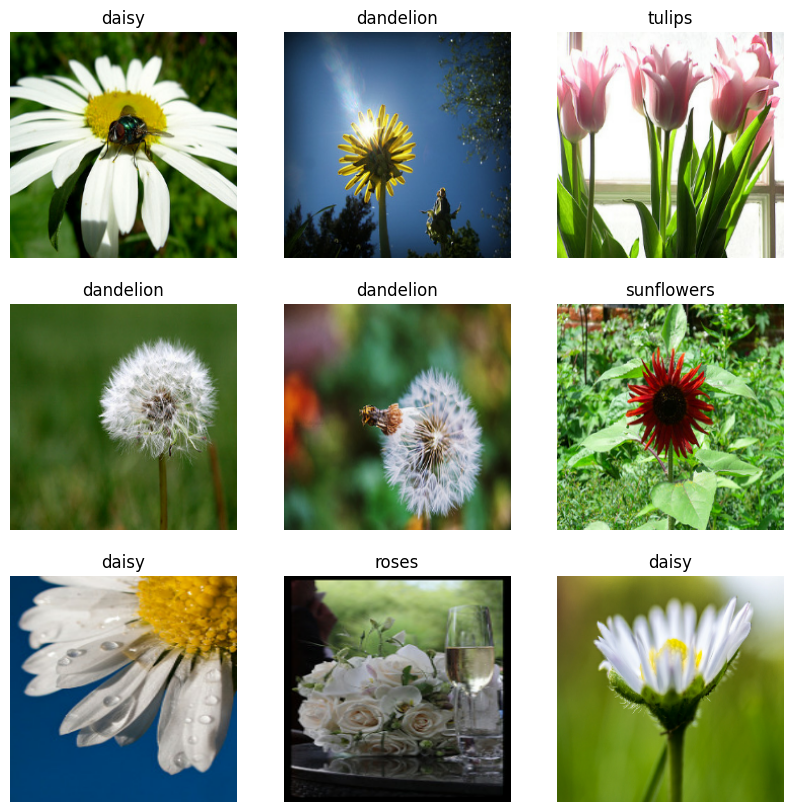

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_index = np.argmax(labels[i])  # convert one-hot label to class index
    plt.title(class_names[class_index])
    plt.axis("off")

## Plot history function

In [ ]:
def plot_history(history):

    sns.set_style('darkgrid')
    sns.set(rc={'figure.figsize': (10, 6)})

    plt.subplot(1, 2, 1)
    loss_plot = sns.lineplot(data=history['loss'], color = 'blue', label= 'Train Loss', lw=1)
    val_loss_plot = sns.lineplot(data=history['val_loss'], color = 'red', label= 'Valid Loss', lw=1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    acc_plot = sns.lineplot(data=history['accuracy'], color = 'blue', label= 'Train Accuracy', lw=1)
    val_acc_plot = sns.lineplot(data=history['val_accuracy'],  color = 'red', label= 'Valid Accuracy', lw=1)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.suptitle('Model Performance', fontsize=14)
    plt.tight_layout()
    plt.show()

# RESNET50 model

In [ ]:
input_t = keras.Input(shape=(224, 224, 3))

resnet_model = keras.applications.ResNet50(include_top=False,
                                        weights="imagenet",
                                        input_tensor=input_t)

94765736/94765736 [==============================] - 3s 0us/step


We freeze all layers except for the last block of ResNet50

In [ ]:
for layer in resnet_model.layers[:143]:
  layer.trainable = False

Let's check the result

In [ ]:
for i, layer in enumerate(resnet_model.layers):
  print(i, layer.name, "-", layer.trainable)

0 input_1 - False
1 conv1_pad - False
2 conv1_conv - False
3 conv1_bn - False
4 conv1_relu - False
5 pool1_pad - False
6 pool1_pool - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
10 conv2_block1_2_conv - False
11 conv2_block1_2_bn - False
12 conv2_block1_2_relu - False
13 conv2_block1_0_conv - False
14 conv2_block1_3_conv - False
15 conv2_block1_0_bn - False
16 conv2_block1_3_bn - False
17 conv2_block1_add - False
18 conv2_block1_out - False
19 conv2_block2_1_conv - False
20 conv2_block2_1_bn - False
21 conv2_block2_1_relu - False
22 conv2_block2_2_conv - False
23 conv2_block2_2_bn - False
24 conv2_block2_2_relu - False
25 conv2_block2_3_conv - False
26 conv2_block2_3_bn - False
27 conv2_block2_add - False
28 conv2_block2_out - False
29 conv2_block3_1_conv - False
30 conv2_block3_1_bn - False
31 conv2_block3_1_relu - False
32 conv2_block3_2_conv - False
33 conv2_block3_2_bn - False
34 conv2_block3_2_relu - False
35 conv2_block3_3_conv - 

In [ ]:
model = keras.models.Sequential()
model.add(resnet_model)

model.add(keras.layers.Flatten())

model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(5, activation='softmax'))

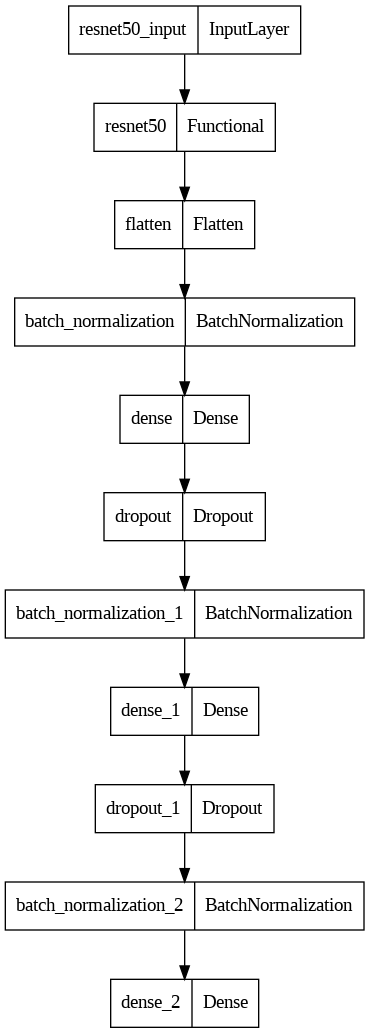

In [ ]:
keras.utils.plot_model(model, to_file='model.png')

Callbacks

In [ ]:
check_point = keras.callbacks.ModelCheckpoint(filepath='ResNet50TL_history.npy',
                                              monitor="val_acc",
                                              mode="max",
                                              save_best_only=True)

Try model

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds,
                    epochs=10,
                    validation_data=val_ds,
                    callbacks=[check_point])

model.summary()
model.save("ResNet50TL_history.npy")

Epoch 1/10
81/81 [==============================] - ETA: 0s - loss: 1.2897 - accuracy: 0.5127

81/81 [==============================] - 43s 211ms/step - loss: 1.2897 - accuracy: 0.5127 - val_loss: 0.6592 - val_accuracy: 0.7904
Epoch 2/10
81/81 [==============================] - ETA: 0s - loss: 0.7780 - accuracy: 0.7135

81/81 [==============================] - 15s 183ms/step - loss: 0.7780 - accuracy: 0.7135 - val_loss: 0.3877 - val_accuracy: 0.8638
Epoch 3/10
81/81 [==============================] - ETA: 0s - loss: 0.5894 - accuracy: 0.8019

81/81 [==============================] - 15s 177ms/step - loss: 0.5894 - accuracy: 0.8019 - val_loss: 0.3988 - val_accuracy: 0.8652
Epoch 4/10
81/81 [==============================] - ETA: 0s - loss: 0.4891 - accuracy: 0.8490

81/81 [==============================] - 15s 178ms/step - loss: 0.4891 - accuracy: 0.8490 - val_loss: 0.3580 - val_accuracy: 0.8825
Epoch 5/10
81/81 [==============================] - ETA: 0s - loss: 0.4012 - accuracy: 0.8895

81/81 [==============================] - 15s 179ms/step - loss: 0.4012 - accuracy: 0.8895 - val_loss: 0.3414 - val_accuracy: 0.8945
Epoch 6/10
81/81 [==============================] - ETA: 0s - loss: 0.3635 - accuracy: 0.8875

81/81 [==============================] - 15s 179ms/step - loss: 0.3635 - accuracy: 0.8875 - val_loss: 0.3367 - val_accuracy: 0.8852
Epoch 7/10
81/81 [==============================] - ETA: 0s - loss: 0.3174 - accuracy: 0.9229

81/81 [==============================] - 15s 180ms/step - loss: 0.3174 - accuracy: 0.9229 - val_loss: 0.3131 - val_accuracy: 0.9039
Epoch 8/10
81/81 [==============================] - ETA: 0s - loss: 0.2604 - accuracy: 0.9358

81/81 [==============================] - 17s 205ms/step - loss: 0.2604 - accuracy: 0.9358 - val_loss: 0.3239 - val_accuracy: 0.9025
Epoch 9/10
81/81 [==============================] - ETA: 0s - loss: 0.2294 - accuracy: 0.9463

81/81 [==============================] - 18s 202ms/step - loss: 0.2294 - accuracy: 0.9463 - val_loss: 0.2807 - val_accuracy: 0.9012
Epoch 10/10
81/81 [==============================] - ETA: 0s - loss: 0.2056 - accuracy: 0.9568

81/81 [==============================] - 16s 191ms/step - loss: 0.2056 - accuracy: 0.9568 - val_loss: 0.2776 - val_accuracy: 0.9065
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 batch_normalization (BatchN  (None, 100352)           401408    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               12845184  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                      

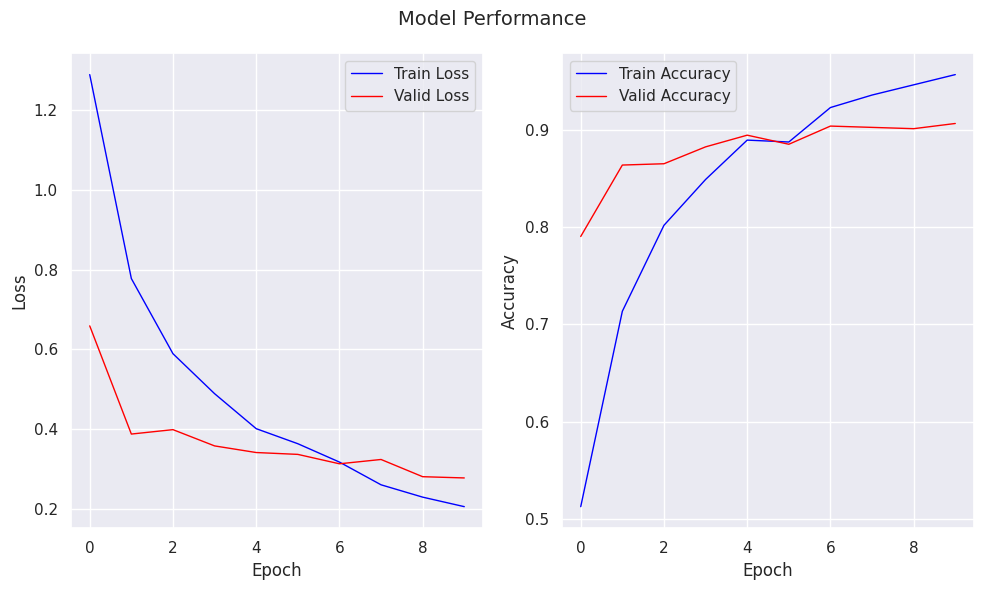

In [ ]:
plot_history(history.history)

## Prepare Keras Data Generators

In [ ]:
from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

image_size = 224
dir_path = "/content/flower_photos"

generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                               validation_split=0.3)

train_generator = generator.flow_from_directory(dir_path,
                                                target_size=(image_size, image_size),
                                                batch_size=32,
                                                subset="training",
                                                class_mode='categorical')

validation_generator = generator.flow_from_directory(dir_path,
                                                     target_size=(image_size, image_size),
                                                     batch_size=32,
                                                     subset="validation",
                                                     class_mode='categorical')


Found 2572 images belonging to 5 classes.
Found 1098 images belonging to 5 classes.


In [ ]:
check_point2 = keras.callbacks.ModelCheckpoint(filepath='ResNet50TL_history2.npy',
                                              monitor="val_acc",
                                              mode="max",
                                              save_best_only=True)

In [ ]:
fit_history = model.fit_generator(train_generator,
                                  epochs = 10,
                                  validation_data=validation_generator,
                                  callbacks=[check_point2]
)


<ipython-input-27-24c0c4e95467>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fit_history = model.fit_generator(train_generator,


Epoch 1/10
81/81 [==============================] - ETA: 0s - loss: 0.3625 - accuracy: 0.8923

81/81 [==============================] - 28s 309ms/step - loss: 0.3625 - accuracy: 0.8923 - val_loss: 0.1749 - val_accuracy: 0.9517
Epoch 2/10
81/81 [==============================] - ETA: 0s - loss: 0.2597 - accuracy: 0.9296

81/81 [==============================] - 22s 275ms/step - loss: 0.2597 - accuracy: 0.9296 - val_loss: 0.1504 - val_accuracy: 0.9590
Epoch 3/10
81/81 [==============================] - ETA: 0s - loss: 0.2093 - accuracy: 0.9498

81/81 [==============================] - 21s 262ms/step - loss: 0.2093 - accuracy: 0.9498 - val_loss: 0.1596 - val_accuracy: 0.9481
Epoch 4/10
81/81 [==============================] - ETA: 0s - loss: 0.1669 - accuracy: 0.9623

81/81 [==============================] - 26s 317ms/step - loss: 0.1669 - accuracy: 0.9623 - val_loss: 0.1578 - val_accuracy: 0.9536
Epoch 5/10
81/81 [==============================] - ETA: 0s - loss: 0.1492 - accuracy: 0.9759

81/81 [==============================] - 21s 257ms/step - loss: 0.1492 - accuracy: 0.9759 - val_loss: 0.1543 - val_accuracy: 0.9508
Epoch 6/10
81/81 [==============================] - ETA: 0s - loss: 0.1452 - accuracy: 0.9701

81/81 [==============================] - 25s 302ms/step - loss: 0.1452 - accuracy: 0.9701 - val_loss: 0.1832 - val_accuracy: 0.9344
Epoch 7/10
81/81 [==============================] - ETA: 0s - loss: 0.1245 - accuracy: 0.9821

81/81 [==============================] - 21s 264ms/step - loss: 0.1245 - accuracy: 0.9821 - val_loss: 0.1685 - val_accuracy: 0.9517
Epoch 8/10
81/81 [==============================] - ETA: 0s - loss: 0.1265 - accuracy: 0.9774

81/81 [==============================] - 22s 266ms/step - loss: 0.1265 - accuracy: 0.9774 - val_loss: 0.1534 - val_accuracy: 0.9536
Epoch 9/10
81/81 [==============================] - ETA: 0s - loss: 0.1176 - accuracy: 0.9790

81/81 [==============================] - 26s 319ms/step - loss: 0.1176 - accuracy: 0.9790 - val_loss: 0.1716 - val_accuracy: 0.9435
Epoch 10/10
81/81 [==============================] - ETA: 0s - loss: 0.1044 - accuracy: 0.9841

81/81 [==============================] - 21s 259ms/step - loss: 0.1044 - accuracy: 0.9841 - val_loss: 0.1516 - val_accuracy: 0.9508


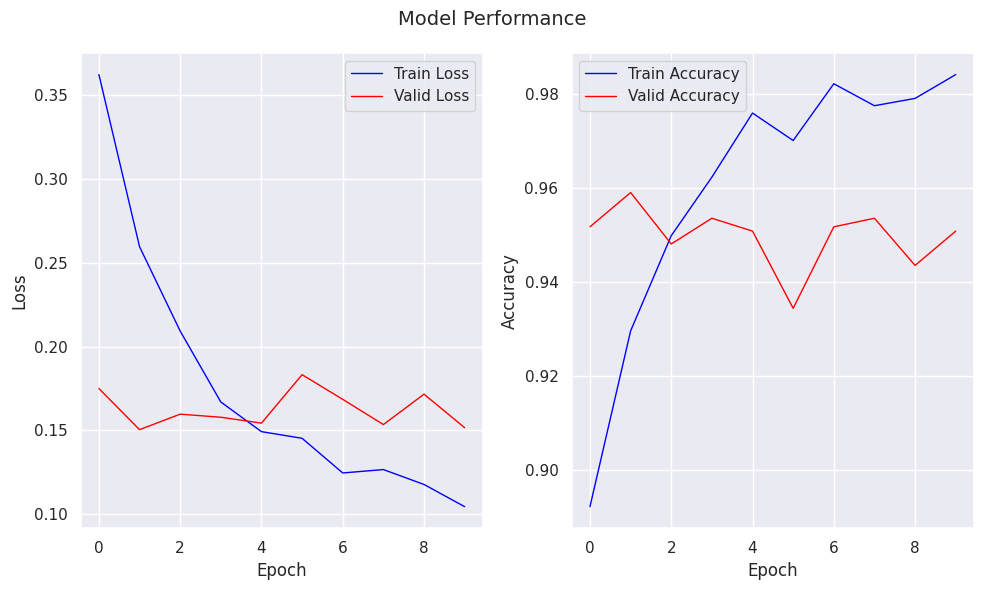

In [ ]:
plot_history(fit_history.history)

In [ ]:
!zip -r /content/ResNet50TL_history.npy.zip /content/ResNet50TL_history.npy

  adding: content/ResNet50TL_history.npy/ (stored 0%)
  adding: content/ResNet50TL_history.npy/saved_model.pb (deflated 91%)
  adding: content/ResNet50TL_history.npy/assets/ (stored 0%)
  adding: content/ResNet50TL_history.npy/keras_metadata.pb (deflated 96%)
  adding: content/ResNet50TL_history.npy/variables/ (stored 0%)
  adding: content/ResNet50TL_history.npy/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/ResNet50TL_history.npy/variables/variables.index (deflated 78%)
  adding: content/ResNet50TL_history.npy/fingerprint.pb (stored 0%)


In [ ]:
from google.colab import files
files.download("/content/ResNet50TL_history.npy.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>